In [12]:
# import basics
import pandas as pd
import numpy as np

# import tools
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# import models
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from lightgbm import LGBMRegressor

# import viz
import altair as alt
alt.renderers.enable('mimetype')

RendererRegistry.enable('mimetype')

In [2]:
df = pd.read_csv("../../data/train.csv")
y = np.log(df['SalePrice']) # using the logarithm as the target
X = df.drop(columns=['SalePrice', 'Id']).copy() # dropped ID col too
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=9527)

In [3]:
# create the list of cols to drop based on missing rate
missing_rates = (X_train.isnull().sum()/X_train.shape[0]).sort_values(ascending=False)[:20]
cols_drop = list(missing_rates[:5].index)

# create list of categorical and numerical columns
cat_cols = [x for x in X_train.columns[[(x=='object') for x in X_train.dtypes]] if x not in cols_drop]
num_cols = [x for x in X_train.columns if (x not in cat_cols) and (x not in cols_drop)]

assert len(cat_cols) + len(num_cols) + len(cols_drop) == X_train.shape[1]

In [4]:
# define pipeline steps
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(np.nan, 'mean')),
    ('scaler', StandardScaler())
])

categoric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan,
                              strategy='most_frequent')),
    ("ohe", OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(remainder='drop', transformers=[
    ('num', numeric_transformer, num_cols),
    ('cat', categoric_transformer, cat_cols)
])

# define base models with default hyp-params
models = {"Dummy": DummyRegressor(), 
         "LinearReg": LinearRegression(),
         "DT": DecisionTreeRegressor(),
         "RF": RandomForestRegressor(),
         "SVM": SVR(),
         "LGBM": LGBMRegressor()}

results = {}

In [5]:
# run all the models with 10-fold CV, RMSE scoring
for model_name, model in models.items():
    ppl = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor', model)]) # create pipeline object
    ppl.fit(X_train, y_train)
    score = cross_val_score(ppl, X_train, y_train, scoring='neg_root_mean_squared_error', cv=10).mean() * -1 # 10-fold cv RMSE score
    
    print("{}: {:.3f}".format(model_name, score))
    
    results[model_name] = score # record model's performance

Dummy: 0.397
LinearReg: 0.147
DT: 0.219
RF: 0.144
SVM: 0.138
LGBM: 0.133


In [6]:
# print out results in df
results_df = pd.DataFrame(index=results.keys())
results_df['10-fold_RMSE'] = results.values()
results_df

,10-fold_RMSE
Dummy,0.397110
LinearReg,0.146650
DT,0.219386
RF,0.143915
SVM,0.137885
LGBM,0.132773


In [7]:
# visualize LGBM's predictions agains y_true on test set
df_viz = pd.DataFrame({"id":range(len(X_test)), 
                       "pred":np.exp(ppl.predict(X_test)),
                      "true": np.exp(y_test)})

df_viz['pred-true'] = df_viz['pred'] - df_viz['true']

# melt for viz
df_viz_melt = df_viz.melt(id_vars='id', 
           var_name='type',
            value_vars=['pred', 'true'],
            value_name='sale_price'
           )

In [8]:
df_viz

,id,pred,true,pred-true
873,0,134196.343937,133000.0,1196.343937
714,1,199791.059281,130500.0,69291.059281
280,2,226059.342621,228500.0,-2440.657379
934,3,219302.349422,242000.0,-22697.650578
310,4,180542.549550,165600.0,14942.549550
...,...,...,...,...
20,433,332737.401013,325300.0,7437.401013
468,434,236524.874649,250000.0,-13475.125351
124,435,162516.385082,181000.0,-18483.614918
487,436,185790.038638,175000.0,10790.038638


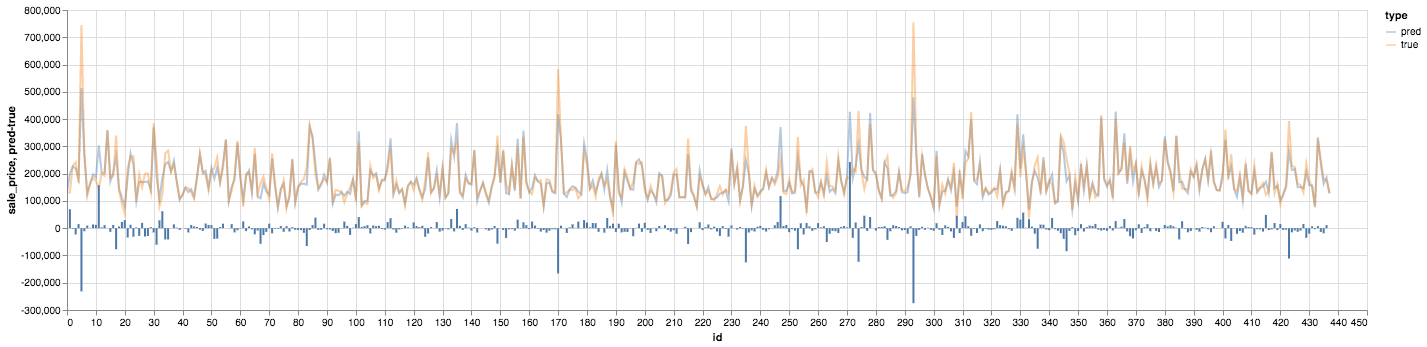

In [24]:
# line plot of y_pred and y_true
plot_line = alt.Chart(df_viz_melt).mark_line(opacity=0.4).encode(
    x='id',
    y='sale_price',
    color='type'
)

# bar plot of diff between pred and true
plot_bar = alt.Chart(df_viz).mark_bar(width=2).encode(
    x=alt.X('id', scale=alt.Scale(domain=(10, 400))),
#     x='id',
    y='pred-true'
)

# aggregated plot
(plot_line + plot_bar).properties(
    width=1300,
    height=300
).interactive()

### looks good yo